当前工作目录： C:\Users\pc_of_han\Documents\code\第四周\week4 02
数据形状: (1757, 27)
缺失值统计:
 City Name       0
Package         0
Variety         5
Origin          3
Item Size     279
Color         616
Date            0
mean_price      0
dtype: int64
目标变量统计:
 count    1757.000000
mean      128.771138
std        86.426495
min         0.240000
25%        24.250000
50%       145.000000
75%       192.500000
max       480.000000
Name: mean_price, dtype: float64
特征维度： (1757, 8)


C:\Users\pc_of_han\Documents\code\第四周\week4 02\scripts\feature_processing.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_processed["Date"] = pd.to_datetime(df_processed["Date"])
C:\Users\pc_of_han\Documents\code\第四周\week4 02\scripts\feature_processing.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
C:\Users\p

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 1171, number of used features: 8
[LightGBM] [Info] Start training from score 128.333890
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1171, number of used features: 8
[LightGBM] [Info] Start training from score 128.372092
[LightGBM] [Warning] Found white

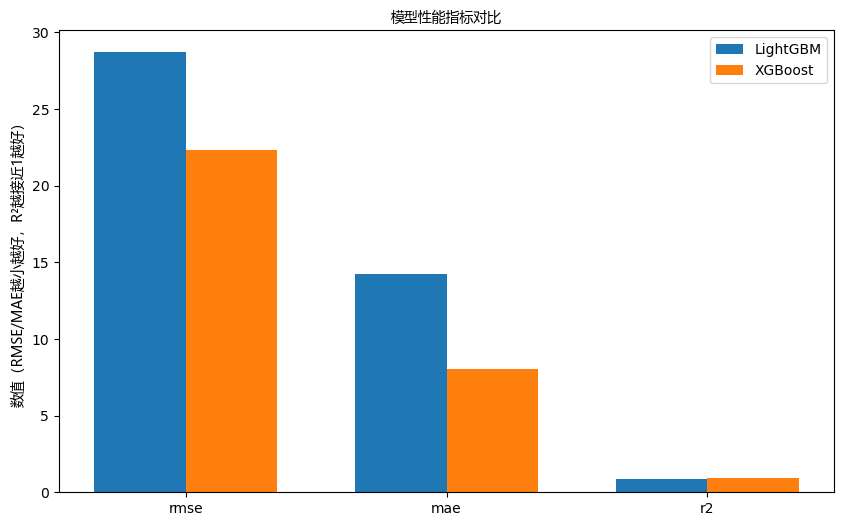

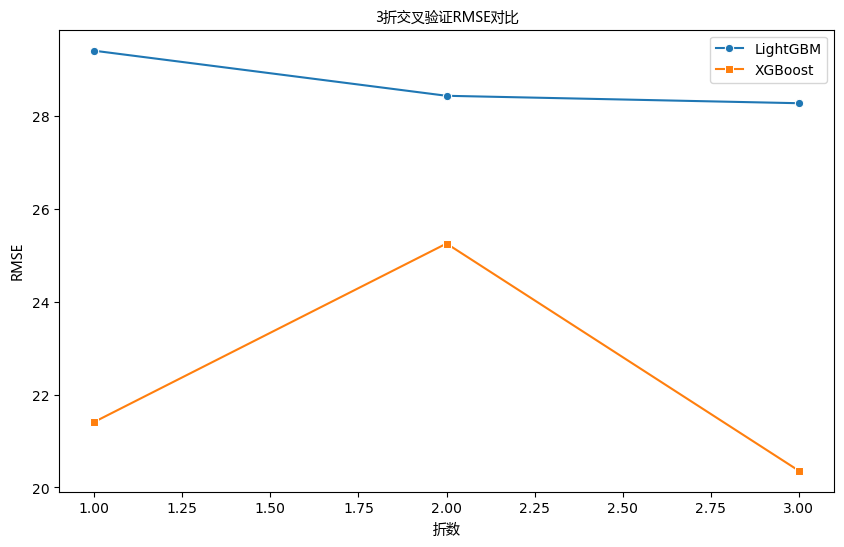

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 1757, number of used features: 8
[LightGBM] [Info] Start training from score 128.771138


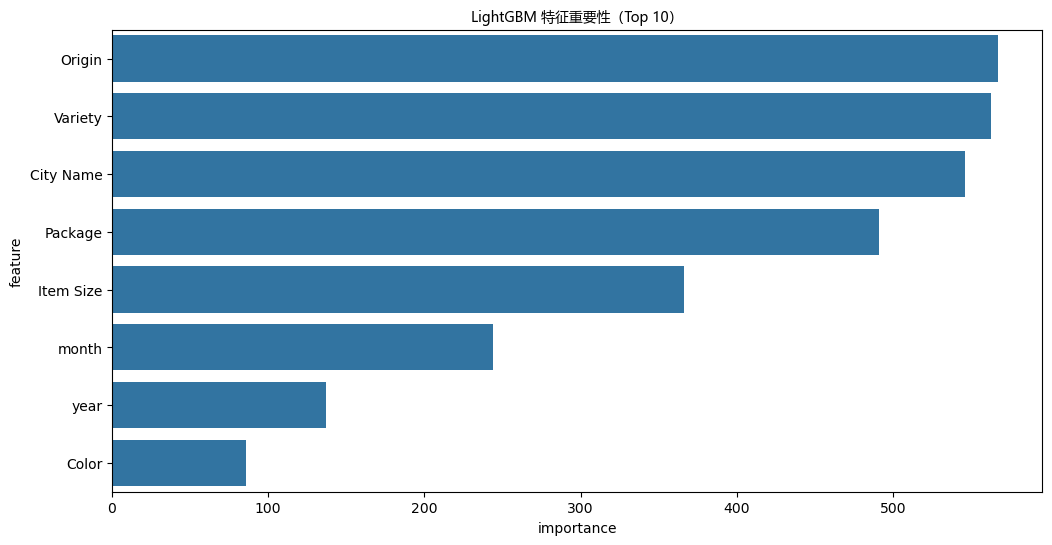

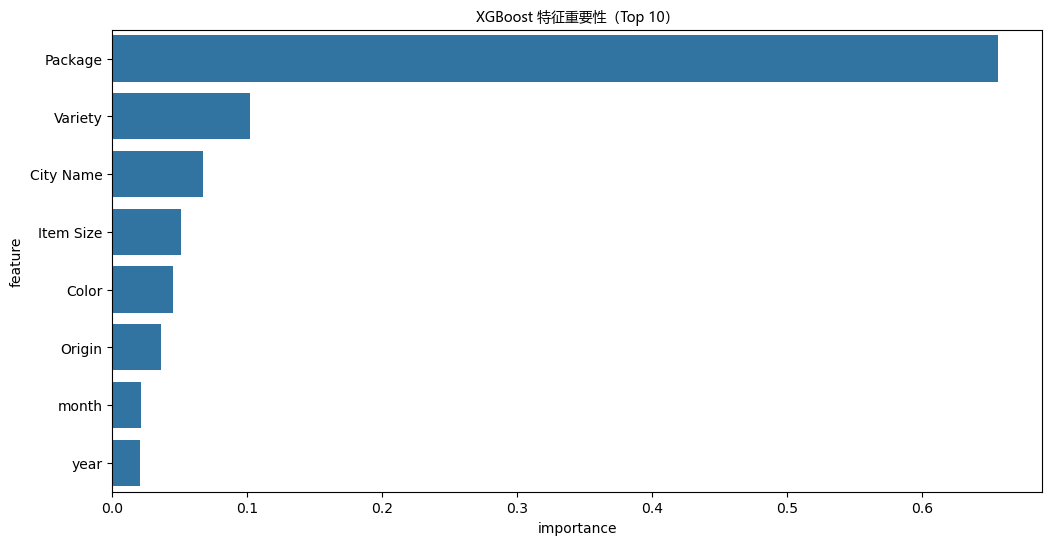

In [2]:
import os
import sys
# 切换到项目根目录（包含 data/、scripts/ 的文件夹）
os.chdir(r"C:\Users\pc_of_han\Documents\code\第四周\week4 02")  
print("当前工作目录：", os.getcwd())  # 确认是否切换成功
# 获取项目根目录（已通过 os.chdir 切换到根目录）
project_root = os.getcwd()  
# 将 scripts 目录加入搜索路径
sys.path.append(os.path.join(project_root, "scripts")) 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scripts.configuration import DATA_PATH, FEATURE_COLUMNS, LGBM_PARAMS, XGBOOST_PARAMS, OUTPUT_JSON_PATH
from scripts.data_analysis import load_data
from scripts.feature_processing import process_features
from scripts.model import get_lgbm_model, get_xgboost_model
from scripts.evaluate import cross_validate
from scripts.utility import save_experiment_results


# 加载数据
data = load_data()

# 处理特征（生成X, y）
X, y, encoder = process_features(data, FEATURE_COLUMNS)

# 查看处理后特征
print("特征维度：", X.shape)
X.head()


# 初始化模型
lgbm = get_lgbm_model(params=LGBM_PARAMS)

# 交叉验证 - 去掉多余的 feature_data 参数
lgbm_cv_results = cross_validate(lgbm, X, y)  # 关键修改：移除 feature_data=X

# 保存结果
save_experiment_results(
    model_name="LGBM",
    model_params=LGBM_PARAMS,
    fea_encoding="ordinal",
    cv_results=lgbm_cv_results
)

# 打印关键结果
print("LGBM 平均测试性能：", lgbm_cv_results["average_test"])


# 初始化模型
xgb_model = get_xgboost_model(params=XGBOOST_PARAMS)

# 交叉验证 - 去掉多余的 feature_data 参数
xgb_cv_results = cross_validate(xgb_model, X, y)  # 关键修改：移除 feature_data=X

# 保存结果
save_experiment_results(
    model_name="XGBoost",
    model_params=XGBOOST_PARAMS,
    fea_encoding="ordinal",
    cv_results=xgb_cv_results
)

# 打印关键结果
print("XGBoost 平均测试性能：", xgb_cv_results["average_test"])


# 从JSON文件读取结果
with open(OUTPUT_JSON_PATH, 'r') as f:
    all_results = json.load(f)

# 提取LGBM和XGBoost的结果
lgbm_res = next(res for res in all_results if res["model_name"] == "LGBM")
xgb_res = next(res for res in all_results if res["model_name"] == "XGBoost")


# 整理性能数据
metrics = ['rmse', 'mae', 'r2']
lgbm_metrics = [lgbm_res["cv_results"]["average_test"][m] for m in metrics]
xgb_metrics = [xgb_res["cv_results"]["average_test"][m] for m in metrics]

# 可视化对比
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, lgbm_metrics, width, label='LightGBM')
plt.bar(x + width/2, xgb_metrics, width, label='XGBoost')

plt.xticks(x, metrics)
plt.title('模型性能指标对比', fontsize=14, fontproperties='Microsoft YaHei')
plt.ylabel('数值（RMSE/MAE越小越好，R²越接近1越好）', fontproperties='Microsoft YaHei')
plt.legend()
plt.show()


# 提取各折测试RMSE
lgbm_fold_rmse = [fold["performance"]["rmse"] for fold in lgbm_res["cv_results"]["fold_test"]]
xgb_fold_rmse = [fold["performance"]["rmse"] for fold in xgb_res["cv_results"]["fold_test"]]

# 可视化折间差异
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(lgbm_fold_rmse)+1), y=lgbm_fold_rmse, marker='o', label='LightGBM')
sns.lineplot(x=range(1, len(xgb_fold_rmse)+1), y=xgb_fold_rmse, marker='s', label='XGBoost')

plt.title('3折交叉验证RMSE对比', fontsize=14, fontproperties='Microsoft YaHei')
plt.xlabel('折数', fontproperties='Microsoft YaHei')
plt.ylabel('RMSE', fontproperties='Microsoft YaHei')
plt.legend()
plt.show()


# 训练最终模型以获取特征重要性
lgbm_final = get_lgbm_model()
lgbm_final.fit(X, y)

xgb_final = get_xgboost_model()
xgb_final.fit(X, y)

# 提取特征名
feature_names = X.columns

# LightGBM特征重要性
lgbm_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

# XGBoost特征重要性
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False)

# 可视化
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=lgbm_importance.head(10))
plt.title('LightGBM 特征重要性（Top 10）', fontsize=14, fontproperties='Microsoft YaHei')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=xgb_importance.head(10))
plt.title('XGBoost 特征重要性（Top 10）', fontsize=14, fontproperties='Microsoft YaHei')
plt.show()